# Network Assembly

The river system has been subsetted to rivers with sites on them, the auto completed river extensions have been calculated, and the manually drawn sections have been created. Now we need to stitch these components together and add them to the coastal network.

In [1]:
%pylab inline
import os
import json
import pyriv
import networkx as nx
import geopandas as gpd
import pandas as pd
import mplleaflet
from shapely.geometry import Point, LinearRing, Polygon, LineString
from shapely.affinity import translate
from shapely import ops
import pyriv.rg_light as rgl
from pyriv.point_processor import save_paths, save_points
from scipy.misc import comb

data_dir = '/Users/jkibele/Documents/RiverDistEastCoast/data/'
fp = lambda s: os.path.join(data_dir, s)

auto_compfn = fp('auto_complete.shp')
drawnfn = fp('draw_qgis.shp')
riv_subset = fp('river_subset.gpickle')
coast_graph_fn = fp('land500m_5070.gpickle')
land_shp_fn = fp('land500m_5070.shp')

Populating the interactive namespace from numpy and matplotlib


Load the river data sets and weight the edges.

In [2]:
auto_riv = rgl.RiverGraph(data=nx.read_shp(auto_compfn)).weight_edges()
drawn_riv = rgl.RiverGraph(data=nx.read_shp(drawnfn)).weight_edges()
riv_sub = rgl.RiverGraph(data=nx.read_gpickle(riv_subset)).weight_edges()

Stick them all together into a full river graph. Round them to make sure nodes are recognized as being the same when they're meant to be. (Floating point error can break the network otherwise). Then save the network as a graph pickle.

In [3]:
reverse_linestring = lambda ls: LineString(ls.coords[::-1])

In [14]:
# full_rgr = nx.compose_all([riv_sub, auto_riv, drawn_riv])
full_rgr = nx.read_gpickle(fp('output/full_rgr.gpickle'))
# this will round nodes to the closest mm. I think that's good enough
full_rgr = pyriv.river_graph.node_rounding(full_rgr, 3)
nx.write_gpickle(full_rgr, fp('full_rgr.gpickle'))

Reverse the graphs and add the reversed edges back in.

In [15]:
from pyriv.rg_light import json_linestring_reverse, full_reverse, add_reverse

In [16]:
# rgr_multi = directed_to_multidirected(full_rgr)

In [17]:
# full_rgr[n0][tpep]
# directed_to_multidirected(full_rgr)[n0][tpep]
# directed_to_multidirected(full_rgr)[tpep][n0]

Load the coastal network, round it, and combine it with the rivers.

In [18]:
coast_graph = nx.read_gpickle(coast_graph_fn)
coast_graph = pyriv.river_graph.node_rounding(coast_graph)
total_multidigraph = add_reverse(nx.compose(nx.DiGraph(full_rgr), coast_graph.to_directed()))
total_unlinked = pyriv.coastal.Land(land_shp_fn, graph=total_multidigraph)

In [19]:
type(total_multidigraph)

networkx.classes.digraph.DiGraph

### Added Ocean Edges for River Ends and Ocean Sites

First, I'll have to get a list of river ends points.

In [20]:
sites = gpd.read_file(fp('sites.shp'))
rgr = rgl.RiverGraph(data=full_rgr)
distdf = rgl.deadend_distances(sites, rgr, True)
myround = lambda f: round(f, 3)
tround = lambda t: tuple([myround(f) for f in t])
path_end_node = lambda pth: tround(pth.coords[-1])
oceanpnts = distdf.query("node_dist >= 4000").geometry.apply(lambda p: tround(pyriv.point_to_tuple(p)))
riv_ends = distdf.query("node_dist < 4000").path.apply(path_end_node)
link_nodes = pd.concat([oceanpnts, riv_ends], ignore_index=True).unique()

In [30]:
distdf.query("node_dist < 4000").path.apply(lambda p: p.is_empty).any()

False

In [21]:
import pickle
pickle.dump(link_nodes, open(fp('link_nodes.pickle'), 'wb'))
len(link_nodes)

87

In [22]:
%%time 
# took just under 9 min on MacBook Pro
full_graph = total_unlinked.add_ocean_edges(link_nodes, n_jobs=7, radius=2e4)
full_graph = add_reverse(full_graph)
nx.write_gpickle(full_graph, fp('total_connected.gpickle'))
# if it's already been run and you don't want to wait:
# full_graph = nx.read_gpickle(fp('total_connected.gpickle'))

CPU times: user 43.9 s, sys: 1.46 s, total: 45.4 s
Wall time: 59.8 s


In [23]:
type(full_graph)

networkx.classes.digraph.DiGraph

## Test with a couple of points

In [24]:
fish_dist = pyriv.coastal.coastal_fish_distance
p0 = sites.loc[sites.Code=='SJR'].geometry.iloc[2]
p1 = sites.geometry.iloc[0]
p2 = sites.geometry.iloc[1]
gdf_from_geoms = lambda gs: gpd.GeoDataFrame({'geometry': gs})
fd_df = gdf_from_geoms([fish_dist(full_graph, p2, p0)])
fd_df.plot(linewidth=4.0, color='r', figsize=(6,6))
mplleaflet.display(epsg=5070)

In [12]:
op0, op1 = oceanpnts.iloc[:2]
op0, op1

((1728612.446, 2043685.658), (1658942.243, 1821575.634))

In [66]:
tpth = distdf.loc[distdf.Code=='SJR','path'].iloc[0]
tpep = path_end_node(tpth)

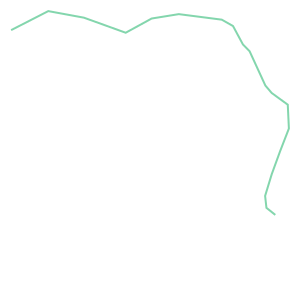

In [77]:
LineString(tpth.coords[::-1])

In [67]:
tpep

(2297330.761, 2846083.857)

In [151]:
n0 = pyriv.coastal.closest_node(full_rgr, p0)
rgr_multi[tpep][n0]

{'Json': '{ "type": "LineString", "coordinates": [ [ 2226419.822791225276887, 2895680.594935759436339 ], [ 2236395.326307798270136, 2900784.371298689395189 ], [ 2245959.351761912927032, 2899023.155884014908224 ], [ 2257176.253446499817073, 2894977.736836523748934 ], [ 2264140.767089489847422, 2898794.447464624419808 ], [ 2271430.818130108062178, 2899971.766216910909861 ], [ 2282959.979424915742129, 2898488.83716952893883 ], [ 2285985.704138903878629, 2896770.87184171192348 ], [ 2288640.176186424214393, 2891839.494079026859254 ], [ 2290431.90914183203131, 2890012.98049052618444 ], [ 2294662.684132322203368, 2880810.98266008682549 ], [ 2296367.89513082196936, 2878800.939001320395619 ], [ 2300678.857486966531724, 2875663.013329821173102 ], [ 2300979.7053739996627, 2869267.104516986291856 ], [ 2298618.185221419669688, 2863166.343734075780958 ], [ 2296371.461586110293865, 2857000.43265745928511 ], [ 2294597.228884864598513, 2851176.86892595840618 ], [ 2294952.881026514805853, 2847984.074367

In [150]:
ed = rgr_multi[n0][tpep]
ed

{'Json': '{ "type": "LineString", "coordinates": [ [ 2226419.822791225276887, 2895680.594935759436339 ], [ 2236395.326307798270136, 2900784.371298689395189 ], [ 2245959.351761912927032, 2899023.155884014908224 ], [ 2257176.253446499817073, 2894977.736836523748934 ], [ 2264140.767089489847422, 2898794.447464624419808 ], [ 2271430.818130108062178, 2899971.766216910909861 ], [ 2282959.979424915742129, 2898488.83716952893883 ], [ 2285985.704138903878629, 2896770.87184171192348 ], [ 2288640.176186424214393, 2891839.494079026859254 ], [ 2290431.90914183203131, 2890012.98049052618444 ], [ 2294662.684132322203368, 2880810.98266008682549 ], [ 2296367.89513082196936, 2878800.939001320395619 ], [ 2300678.857486966531724, 2875663.013329821173102 ], [ 2300979.7053739996627, 2869267.104516986291856 ], [ 2298618.185221419669688, 2863166.343734075780958 ], [ 2296371.461586110293865, 2857000.43265745928511 ], [ 2294597.228884864598513, 2851176.86892595840618 ], [ 2294952.881026514805853, 2847984.074367

In [152]:
full_rgr.reverse()[tpep][n0]

{'Json': '{ "type": "LineString", "coordinates": [ [ 2226419.822791225276887, 2895680.594935759436339 ], [ 2236395.326307798270136, 2900784.371298689395189 ], [ 2245959.351761912927032, 2899023.155884014908224 ], [ 2257176.253446499817073, 2894977.736836523748934 ], [ 2264140.767089489847422, 2898794.447464624419808 ], [ 2271430.818130108062178, 2899971.766216910909861 ], [ 2282959.979424915742129, 2898488.83716952893883 ], [ 2285985.704138903878629, 2896770.87184171192348 ], [ 2288640.176186424214393, 2891839.494079026859254 ], [ 2290431.90914183203131, 2890012.98049052618444 ], [ 2294662.684132322203368, 2880810.98266008682549 ], [ 2296367.89513082196936, 2878800.939001320395619 ], [ 2300678.857486966531724, 2875663.013329821173102 ], [ 2300979.7053739996627, 2869267.104516986291856 ], [ 2298618.185221419669688, 2863166.343734075780958 ], [ 2296371.461586110293865, 2857000.43265745928511 ], [ 2294597.228884864598513, 2851176.86892595840618 ], [ 2294952.881026514805853, 2847984.074367

In [124]:
G = nx.path_graph(3)
bb = nx.edge_betweenness_centrality(G, normalized=False)
nx.set_edge_attributes(G, 'betweenness', bb)
G[1][2]['betweenness']

2.0

In [125]:
bb

{(0, 1): 2.0, (1, 2): 2.0}

In [126]:
nx.get_edge_attributes(G, 'betweenness')

{(0, 1): 2.0, (1, 2): 2.0}

In [127]:
for n0,n1 in G.edges_iter():
    print n0, n1

0 1
1 2


In [246]:
for k,v in {'pork':'chop','foo':'bar'}.iteritems():
    print k, v

pork chop
foo bar
